# _he who has a how can bear almost any why_

We seek to extract a representative but manageable subset of queries from a [448m dump of Bing queries](https://archive.org/details/2019-search-engine-keyphrases.json), 2017-2019. (See [Reddit discussion](https://www.reddit.com/r/datasets/comments/euq7iq/448_million_search_engine_queries_from_20172019/))

Let's do this thing.

In [1]:
%pip install pyspark pandas sklearn cupy-cuda12x matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 8.3 MB/s eta 0:00:00m eta 0:00:010:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 28.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=0eb7a8cce566ef2b32da954b26b21035af83743d3606cb945261f39f2bdc142b
  Stored in directory: /home/ritsuko/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("JSON_keyphrases") \
    .config('spark.driver.memory', '12g') \
    .config('spark.executor.memory', '8g') \
    .config("spark.master", "local[*]") \
    .getOrCreate()


KeyboardInterrupt: 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Exception in thread "main" java.nio.file.NoSuchFileException: /tmp/tmpfop6ycll/connection737573939341697572.info
	at java.base/sun.nio.fs.UnixException.translateToIOException(UnixException.java:92)
	at java.base/sun.nio.fs.UnixException.rethrowAsIOException(UnixException.java:106)
	at java.base/sun.nio.fs.UnixException.rethrowAsIOException(UnixException.java:111)
	at java.base/sun.nio.fs.UnixFileSystemProvider.newByteChannel(UnixFileSystemProvider.java:261)
	at java.base/java.nio.file.Files.newByteChannel(Files.java:379)
	at java.base/java.nio.file.Files.createFile(Files.java:657)
	at java.base/java.nio.file.TempFileHelper.create(TempFileHelper.java:136)
	at java.base/java.nio.file.TempFileHelper.createTempFile(TempFileHelper.java:159)
	at java.base/java.nio.file.Files.createTempFile(Files.java:878)
	at org.apache.spark.api.python.PythonGatewayServer$.main(P

In [2]:
df = spark.read.json("./2019-search-engine-keyphrases.json/keyphrases.json")

23/10/19 23:18:45 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Basic preprocessing

Let's get rid of the ID column:

In [3]:
# Remove the "_id" column
df = df.drop("_id")

Now let's remove the empty and redundant trends:

In [4]:
from pyspark.sql import functions as F

# Filter rows where the 'trend' column is not an empty array
df = df.filter(F.size(df.trend) > 0)

# Drop duplicate 'keyphrase' rows
df = df.dropDuplicates(["keyphrase"])


In [6]:
df.coalesce(50).write.format("parquet").mode("overwrite").save("queries_filtered.parquet")

## Removing time-series info

In [8]:
from pyspark.sql import functions as F

# Create a new column containing the size of each array
df = df.withColumn('array_size', F.size('trend'))

# Sum the elements of each array
df = df.withColumn('array_sum', F.expr('aggregate(trend, cast(0 as bigint), (acc, x) -> acc + x)'))

# Compute the average of each array (sum/size)
df = df.withColumn('array_avg', (F.col('array_sum') / F.col('array_size')))

# Optionally, remove the helper columns
df = df.drop('array_sum', 'array_size')

In [9]:
df = df.drop('trend')
df.coalesce(50).write.format("parquet").mode("overwrite").save("queries_filtered.parquet")

## Understanding our dataset


In [3]:
# Load the parquet file in pyspark
raw_df = spark.read.parquet("queries_filtered.parquet")

Looks like we have more cleaning to do.

In [4]:
from pyspark.sql.functions import col, trim, regexp_replace, sum as _sum

cleaned_df = raw_df.withColumn("clean_keyphrase",
                           trim(regexp_replace(regexp_replace(col("keyphrase"), r"^[#+.`]+|[#+.`]+$", ""), r"[#+.`]", " ")))

df = cleaned_df.groupBy("clean_keyphrase").agg(_sum("array_avg").alias("avg_score"))

In [5]:
df_preview = df.limit(4)
df_preview.show()

23/10/21 16:23:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 16:23:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 16:23:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 16:23:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 16:23:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 16:23:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 16:23:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 16:23:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 16:23:52 WARN RowBasedKeyValueBatch: Calling spill() on

+-------------------+------------------+
|    clean_keyphrase|         avg_score|
+-------------------+------------------+
|6 5 creedmoor upper|1.6666666666666667|
|   charitable bonds|               2.5|
|         polar bear|134043.33333333334|
|             beenie|             860.0|
+-------------------+------------------+



Let's examine how Pareto this dataset actually is...

In [5]:
%pip install 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Obviously this won't fit into memory, so let's thin the herd.

In [7]:
import cupy as cp

# Take a 1% sample of the dataset
df_sample = df.sample(False, 0.01, 42)
# Extract array_avg column as a cupy array
avgs = cp.array(df_sample.select('array_avg').collect())

In [27]:

# Sort the data in ascending order
sorted_avgs = cp.sort(avgs)

# Create a rank array
ranks = cp.arange(1, len(sorted_avgs) + 1)

# Flip the rank array for a heavy-tail plot (highest rank first)
ranks = len(sorted_avgs) + 1 - ranks


Visually, let's do a log-log plot.

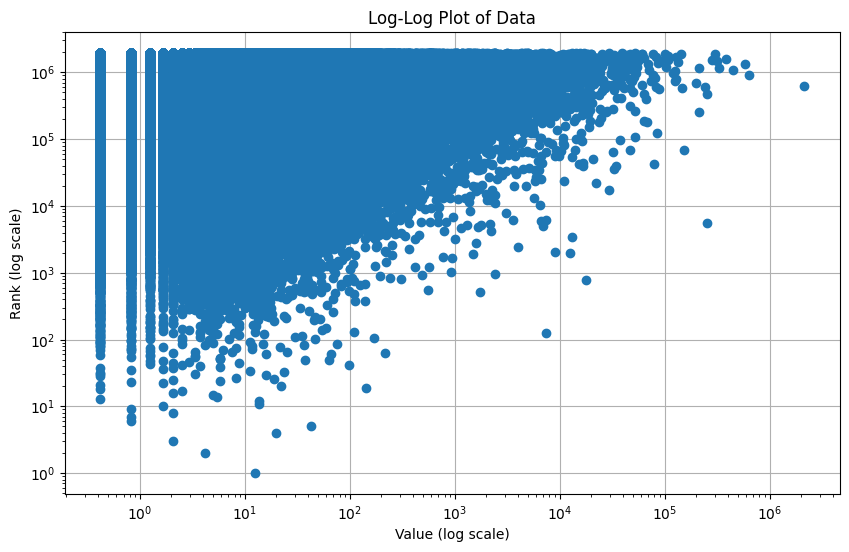

In [28]:
import matplotlib.pyplot as plt

# Generate the log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(sorted_avgs.get(), ranks.get(), marker='o', linestyle='None')
plt.title('Log-Log Plot of Data')
plt.xlabel('Value (log scale)')
plt.ylabel('Rank (log scale)')
plt.grid(True)

# Show the plot
plt.show()

Can we fit a Pareto to this? not really, it's more extreme even than that:

In [22]:
# Get candidate values for xmin and alpha based on quantiles
# 10 candidate percentiles
percentiles = cp.linspace(0.1, 0.95, 10)
percentile_values = cp.quantile(avgs, percentiles)


In [23]:
best_ksize = cp.inf
best_xmin = None
best_alpha = None

for x_min in percentile_values:
    # Filter data
    filtered_avgs = avgs[avgs > x_min]

    # Compute the number of elements in the sample that are greater than x_min
    if filtered_avgs.size == 0:
        continue

    # Compute Pareto alpha
    n = filtered_avgs.size
    log_term = cp.log(filtered_avgs / x_min)
    sum_log_term = cp.sum(log_term)
    alpha_mle = n / sum_log_term


    # Compute empirical CDF of filtered_avgs
    sorted_data = cp.sort(filtered_avgs)
    empirical_cdf = cp.arange(1, n + 1) / n

    # compute theoretical CDF
    theoretical_cdf = 1 - (sorted_data / x_min) ** -alpha_mle

    # Compute ks statistic
    ks_statistic = cp.max(cp.abs(empirical_cdf - theoretical_cdf))

    print(f"x_min: {best_xmin}")
    print(f"alpha: {best_alpha}")
    print(f"ks_statistic: {ks_statistic}")

    # Update best parameters
    if ks_statistic < best_ksize:
        best_ksize = ks_statistic
        best_xmin = x_min
        best_alpha = alpha_mle


x_min: None
alpha: None
ks_statistic: 0.25532770003922584
x_min: 0.4166666666666667
alpha: 0.42532365925057947
ks_statistic: 0.25532770003922584
x_min: 0.4166666666666667
alpha: 0.42532365925057947
ks_statistic: 0.19389823856636917
x_min: 0.8333333333333334
alpha: 0.5190965617403588
ks_statistic: 0.1688869592576368
x_min: 1.25
alpha: 0.5862799826436734
ks_statistic: 0.14060961575993858
x_min: 2.0833333333333335
alpha: 0.6870362863654371
ks_statistic: 0.1145455872935437
x_min: 3.3333333333333335
alpha: 0.7963256460921466
ks_statistic: 0.08953543985523651
x_min: 5.0
alpha: 0.9005491956131699
ks_statistic: 0.05831902090306067
x_min: 7.916666666666667
alpha: 1.0147002241613192
ks_statistic: 0.032738028664016004
x_min: 13.333333333333334
alpha: 1.0818282741793195
ks_statistic: 0.02440742054993822


In [11]:
print(f"Best x_min: {best_xmin}")
print(f"Best alpha: {best_alpha}")

Best x_min: 1937643.6962365597
Best alpha: 9.82485491503288


## Creating a representative subset of 1m queries

We hard cut in the top 100k. Then we perform weighted sampling on the long tail.

In [7]:
top_queries = df.orderBy('avg_score', ascending=False).limit(int(8e5))

In [10]:
from pyspark.sql.functions import rand

# Assuming the data is already sorted based on some criteria (e.g., frequency)
long_tail = df.subtract(top_queries)

# Sample 200k uniformly at random from the long tail
sampled_long_tail = long_tail.sample(withReplacement=False, fraction=2e5/long_tail.count())

# Now you can union this with your top 800k if needed
final_data = top_queries.union(sampled_long_tail)


23/10/21 17:55:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:55:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:55:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:55:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:55:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:55:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:55:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:55:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:55:03 WARN RowBasedKeyValueBatch: Calling spill() on

In [11]:
final_data.coalesce(10).write.format("parquet").mode("overwrite").save("queries_80_20.parquet")

23/10/21 17:58:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:58:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:58:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:58:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:58:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:58:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:58:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:58:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/10/21 17:58:17 WARN RowBasedKeyValueBatch: Calling spill() on